# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [17]:
import numpy as np
import os
from scipy.misc import imread, imresize
from skimage.transform import resize
import datetime
import os
import datetime

We set the random seed so that the results don't vary drastically.

In [18]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [19]:
!ls

Neural_Nets_Project_Starter_Code.ipynb
Neural_Nets_Project_Starter_Code_Conv3D.ipynb
Neural_Nets_Project_Starter_Code_acc.ipynb
Project_data
Project_data.zip
model_init_2019-12-2216_12_18.040803
model_init_2019-12-2312_38_52.707129
model_init_2019-12-2313_08_27.879381
model_init_2019-12-2313_33_31.267301


In [20]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [21]:
image_x_shape = 100
image_y_shape = 100

In [22]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30, 3)) #create a list of image numbers you want to use for a particular video
    x, y, z = len(img_idx), image_x_shape, image_y_shape
    while True:
        t = np.random.permutation(folder_list)
        total_folders = len(folder_list)
        num_batches = total_folders // batch_size #<TODO># calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    resizedImage = resize(image, (y, z),anti_aliasing=True)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = resizedImage[:, :, 0] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resizedImage[:, :, 1] / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resizedImage[:, :, 2] / 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
            
        missing_count = total_folders - (num_batches * batch_size)
        for folder in range(missing_count):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                resizedImage = resize(image, (y, z),anti_aliasing=True)
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes

                batch_data[folder,idx,:,:,0] = resizedImage[:, :, 0] / 255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = resizedImage[:, :, 1] / 255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = resizedImage[:, :, 2] / 255 #normalise and feed in the image

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [23]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [24]:
from keras.models import Sequential, Model
from sklearn.metrics import roc_auc_score
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv2D, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, regularizers
from keras.regularizers import l2
import keras

#write your model here




Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [25]:
reduceLR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2,
                             verbose = 1, mode = "auto", cooldown = 0)

In [26]:
class DecayLR(keras.callbacks.Callback):
    
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.lr_history = []
        self.decay_epoch = decay_epoch
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)
        
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [31]:
class Convolution2DWithGRU():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
#         cnn_model.add(Dense(20))
        
        cnn_model.add(Dense(16))
        cnn_model.add(Dropout(.50))
        cnn_model.add(GRU(64, return_sequences=False))
#         cnn_model.add(Dense(32))
        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

In [32]:
obj = Convolution2DWithGRU()
model = obj.model(batch_size)
optimiser = optimizers.Adam() #write your optimizer

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_64 (TimeDis (None, 10, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_65 (TimeDis (None, 10, 100, 100, 32)  0         
_________________________________________________________________
time_distributed_66 (TimeDis (None, 10, 49, 49, 32)    0         
_________________________________________________________________
time_distributed_67 (TimeDis (None, 10, 49, 49, 32)    128       
_________________________________________________________________
time_distributed_68 (TimeDis (None, 10, 49, 49, 32)    9248      
_________________________________________________________________
time_distributed_69 (TimeDis (None, 10, 49, 49, 32)    0         
_________________________________________________________________
time_distributed_70 (TimeDis (None, 10, 24, 24, 32)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [33]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [34]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
    
early_stopping = EarlyStopping(patience=3)        

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR(base_lr=0.1) # write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]
# roc_callback = RocCallback()
callbacks_list = [checkpoint,reduceLR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [35]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [36]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val Source path =  ; batch size = 30
./Project_data/train ; batch size = 30
Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


 3/23 [==>...........................] - ETA: 1:22 - loss: 5.4347 - categorical_accuracy: 0.2222

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


23/23 [==============================] - 62s 3s/step - loss: 4.5061 - categorical_accuracy: 0.2580 - val_loss: 3.5094 - val_categorical_accuracy: 0.3833

Epoch 00001: saving model to model_init_2019-12-2313_59_05.539691/model-00001-4.50607-0.25797-3.50935-0.38333.h5
Epoch 2/30
23/23 [==============================] - 60s 3s/step - loss: 2.7968 - categorical_accuracy: 0.4130 - val_loss: 2.0947 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2019-12-2313_59_05.539691/model-00002-2.79683-0.41304-2.09467-0.60000.h5
Epoch 3/30
23/23 [==============================] - 51s 2s/step - loss: 1.9570 - categorical_accuracy: 0.5072 - val_loss: 1.8880 - val_categorical_accuracy: 0.5083

Epoch 00003: saving model to model_init_2019-12-2313_59_05.539691/model-00003-1.95700-0.50725-1.88801-0.50833.h5
Epoch 4/30
23/23 [==============================] - 48s 2s/step - loss: 1.6295 - categorical_accuracy: 0.5507 - val_loss: 1.4770 - val_categorical_accuracy: 0.6250

Epoch 00004:

23/23 [==============================] - 60s 3s/step - loss: 0.6700 - categorical_accuracy: 0.8507 - val_loss: 0.9635 - val_categorical_accuracy: 0.7333

Epoch 00028: saving model to model_init_2019-12-2313_59_05.539691/model-00028-0.66999-0.85072-0.96354-0.73333.h5

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
Epoch 29/30
23/23 [==============================] - 57s 2s/step - loss: 0.6649 - categorical_accuracy: 0.8638 - val_loss: 0.9816 - val_categorical_accuracy: 0.7417

Epoch 00029: saving model to model_init_2019-12-2313_59_05.539691/model-00029-0.66486-0.86377-0.98157-0.74167.h5
Epoch 30/30
23/23 [==============================] - 54s 2s/step - loss: 0.6588 - categorical_accuracy: 0.8681 - val_loss: 0.9870 - val_categorical_accuracy: 0.7500

Epoch 00030: saving model to model_init_2019-12-2313_59_05.539691/model-00030-0.65882-0.86812-0.98705-0.75000.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.


In [37]:
print(model_history.history)

{'val_loss': [3.5093533992767334, 2.0946704149246216, 1.8880118131637573, 1.4769676327705383, 1.5282238721847534, 1.2241610288619995, 1.2369094491004944, 1.2912789583206177, 0.9080227464437485, 0.9247587323188782, 0.9181521087884903, 0.8858945071697235, 0.967716634273529, 0.88426873087883, 0.9182396233081818, 0.9070174098014832, 0.957000732421875, 0.8986873775720596, 0.9274831414222717, 0.9352889209985733, 0.9033751785755157, 0.8946778625249863, 1.0078523457050323, 0.9652715921401978, 0.941851481795311, 1.0133633762598038, 0.9834576994180679, 0.9635410904884338, 0.981567457318306, 0.9870458394289017], 'val_categorical_accuracy': [0.38333334028720856, 0.5999999940395355, 0.5083333402872086, 0.6250000149011612, 0.5916666612029076, 0.675000011920929, 0.6666666865348816, 0.625, 0.7500000149011612, 0.7333333343267441, 0.7416666746139526, 0.783333346247673, 0.7583333402872086, 0.7999999821186066, 0.7666666507720947, 0.7583333253860474, 0.7416666746139526, 0.7833333164453506, 0.75833334028720

In [38]:
print(model_history.history['val_categorical_accuracy'])

[0.38333334028720856, 0.5999999940395355, 0.5083333402872086, 0.6250000149011612, 0.5916666612029076, 0.675000011920929, 0.6666666865348816, 0.625, 0.7500000149011612, 0.7333333343267441, 0.7416666746139526, 0.783333346247673, 0.7583333402872086, 0.7999999821186066, 0.7666666507720947, 0.7583333253860474, 0.7416666746139526, 0.7833333164453506, 0.7583333402872086, 0.7500000149011612, 0.7749999910593033, 0.7999999821186066, 0.7416666597127914, 0.7583333253860474, 0.7750000059604645, 0.7166666686534882, 0.7666666805744171, 0.7333333492279053, 0.7416666597127914, 0.7499999850988388]


In [39]:
import matplotlib.pyplot as plt

class PlotMetrics():
    
    def draw(self, history):
        # ===> loss summary
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
        f.set_figheight(5)
        f.set_figwidth(15)
        
        ax1.plot(history.history['val_categorical_accuracy'])
        ax1.plot(history.history['categorical_accuracy'])
        ax1.title.set_text('model accuracy')
        ax1.set_ylabel('accuracy')
        ax1.set_xlabel('epoch')
        ax1.legend(['train', 'test'], loc='upper left')
        
        ax2.plot(history.history['val_loss'])
        ax2.plot(history.history['loss'])
        ax2.title.set_text('Loss function')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('epoch')
        ax2.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        

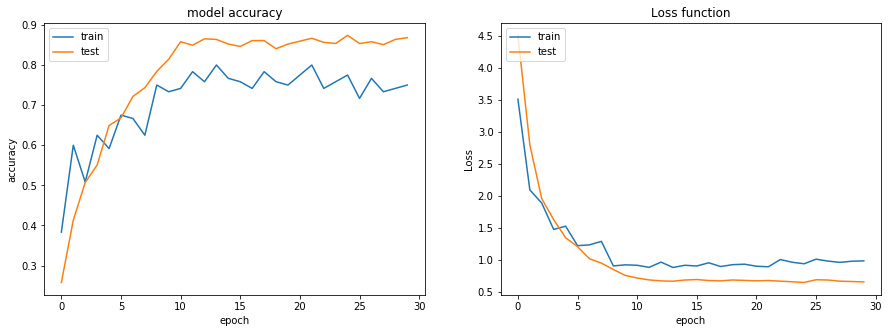

In [40]:
obj= PlotMetrics()
obj.draw(model_history)

### Conv3D Model: 

In [42]:
class convolution3D():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, 100, 100, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1),dim_ordering='th'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),dim_ordering='th'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),dim_ordering='th'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model

In [43]:
obj = convolution3D()
conv3d_model = obj.model(batch_size)
conv3d_optimiser = optimizers.Adam() #write your optimizer

conv3d_model.compile(optimizer=conv3d_optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model.summary())

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 1), data_format="channels_first")`
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 1), data_format="channels_first")`
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 2), data_format="channels_first")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 10, 100, 100, 8)   656       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 50, 50, 8)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 5, 50, 50, 8)      32        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 50, 50, 16)     3472      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 25, 25, 16)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 2, 25, 25, 16)     64        
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 25, 25, 32)     13856     
__________

In [44]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR(base_lr=0.1) # write the REducelronplateau code here
# callbacks_list = [checkpoint, LR]
# roc_callback = RocCallback()
callbacks_list = [reduceLR,checkpoint]

In [46]:
conv3d_model_history = conv3d_model.fit_generator(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


23/23 [==============================] - 54s 2s/step - loss: 1.5871 - categorical_accuracy: 0.6464 - val_loss: 1.5180 - val_categorical_accuracy: 0.7000

Epoch 00001: saving model to model_init_2019-12-2313_59_05.539691/model_3d-00001-1.58707-0.64638-1.51798-0.70000.h5
Epoch 2/30
23/23 [==============================] - 53s 2s/step - loss: 1.5354 - categorical_accuracy: 0.6667 - val_loss: 1.5474 - val_categorical_accuracy: 0.7167

Epoch 00002: saving model to model_init_2019-12-2313_59_05.539691/model_3d-00002-1.53535-0.66667-1.54744-0.71667.h5
Epoch 3/30
23/23 [==============================] - 52s 2s/step - loss: 1.5711 - categorical_accuracy: 0.6696 - val_loss: 1.4990 - val_categorical_accuracy: 0.7250

Epoch 00003: saving model to model_init_2019-12-2313_59_05.539691/model_3d-00003-1.57110-0.66957-1.49899-0.72500.h5
Epoch 4/30
23/23 [==============================] - 57s 2s/step - loss: 1.5932 - categorical_accuracy: 0.6449 - val_loss: 1.5007 - val_categorical_accuracy: 0.7250

Epo

23/23 [==============================] - 51s 2s/step - loss: 1.5429 - categorical_accuracy: 0.7000 - val_loss: 1.5006 - val_categorical_accuracy: 0.7250

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.0000000830368326e-17.

Epoch 00027: saving model to model_init_2019-12-2313_59_05.539691/model_3d-00027-1.54294-0.70000-1.50055-0.72500.h5
Epoch 28/30
23/23 [==============================] - 48s 2s/step - loss: 1.5385 - categorical_accuracy: 0.6797 - val_loss: 1.5040 - val_categorical_accuracy: 0.7250

Epoch 00028: saving model to model_init_2019-12-2313_59_05.539691/model_3d-00028-1.53848-0.67971-1.50396-0.72500.h5
Epoch 29/30
23/23 [==============================] - 49s 2s/step - loss: 1.5437 - categorical_accuracy: 0.6507 - val_loss: 1.5055 - val_categorical_accuracy: 0.7083

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000664932204e-18.

Epoch 00029: saving model to model_init_2019-12-2313_59_05.539691/model_3d-00029-1.54367-0.65072-1.50549-0.70833.h5
Ep

{'val_loss': [1.5179769396781921, 1.5474407076835632, 1.4989860653877258, 1.5007160007953644, 1.5322453379631042, 1.479166179895401, 1.4908965528011322, 1.500350147485733, 1.4610944986343384, 1.4848176538944244, 1.5259747803211212, 1.5539915561676025, 1.5230145454406738, 1.5091828107833862, 1.5146571099758148, 1.4967837035655975, 1.5340461432933807, 1.501619666814804, 1.546604871749878, 1.5032682716846466, 1.533136010169983, 1.5300008654594421, 1.527568280696869, 1.5327436029911041, 1.5150738954544067, 1.5115582048892975, 1.5005511939525604, 1.5039639174938202, 1.5054857432842255, 1.5198813080787659], 'val_categorical_accuracy': [0.699999988079071, 0.7166666835546494, 0.7250000089406967, 0.7250000089406967, 0.7083333283662796, 0.7333333343267441, 0.7666666656732559, 0.7333333343267441, 0.7333333343267441, 0.7333333343267441, 0.6916666775941849, 0.7083333283662796, 0.7166666686534882, 0.7083333432674408, 0.7250000089406967, 0.7249999940395355, 0.7083333283662796, 0.6833333373069763, 0.7

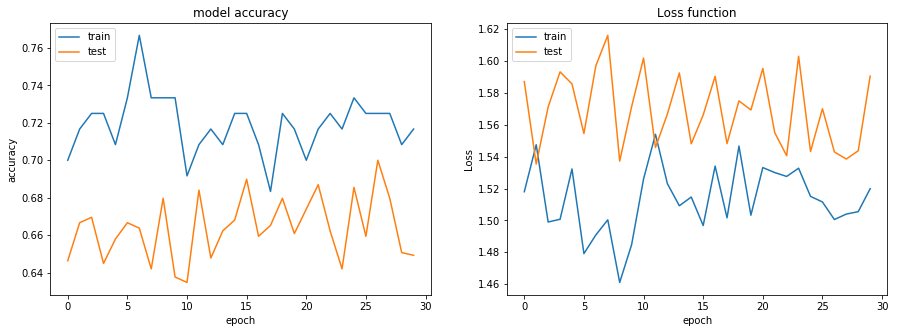

In [47]:
print(conv3d_model_history.history)
obj= PlotMetrics()
obj.draw(conv3d_model_history)